<a href="https://colab.research.google.com/github/Polina444/ml-cource_hw/blob/main/Lab2_DL_part2_overfitting_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import torch.optim as optim



device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:02<00:00, 10888629.16it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173569.61it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3243654.28it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6651964.57it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
           nn.BatchNorm1d(input_shape, affine=False, momentum=0.2),
            nn.Linear(input_shape, 300),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.BatchNorm1d(50, momentum=0.2),
            nn.ReLU(),
            nn.Linear(50, num_classes),
            nn.LogSoftmax(dim=1)

        )
    def forward(self, inp):
        print(f"Input shape: {inp.shape}")
        out = self.model(inp)
        print(f"Output shape: {out.shape}")
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

Input shape: torch.Size([2, 784])
Output shape: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]               0
            Linear-3                  [-1, 300]         235,500
           Dropout-4                  [-1, 300]               0
              ReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 200]          60,200
              ReLU-7                  [-1, 200]               0
            Linear-8                  [-1, 150]          30,150
              ReLU-9                  [-1, 150]               0
           Linear-10                   [-1, 50]           7,550
      BatchNorm1d-11                   [-1, 50]             100
             ReLU-12                   [-1, 50]               0
           Linear-13               

Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = optim.Adam(params=model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
best_accuracy = 0.0

for epoch in range(epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_func(outputs, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss += loss.item()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, running_loss/len(train_loader)))


    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Выходные данные были обрезаны до нескольких последних строк (5000).
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])
Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 1

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 400]                 314,000
|    └─ReLU: 2-3                         [-1, 400]                 --
|    └─Linear: 2-4                       [-1, 400]                 160,400
|    └─ReLU: 2-5                         [-1, 400]                 --
|    └─Linear: 2-6                       [-1, 300]                 120,300
|    └─ReLU: 2-7                         [-1, 300]                 --
|    └─Linear: 2-8                       [-1, 200]                 60,200
|    └─ReLU: 2-9                         [-1, 200]                 --
|    └─Linear: 2-10                      [-1, 100]                 20,100
|    └─ReLU: 2-11                        [-1, 100]                 --
|    └─Linear: 2-12                      [-1, 100]            

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 400]                 314,000
|    └─ReLU: 2-3                         [-1, 400]                 --
|    └─Linear: 2-4                       [-1, 400]                 160,400
|    └─ReLU: 2-5                         [-1, 400]                 --
|    └─Linear: 2-6                       [-1, 300]                 120,300
|    └─ReLU: 2-7                         [-1, 300]                 --
|    └─Linear: 2-8                       [-1, 200]                 60,200
|    └─ReLU: 2-9                         [-1, 200]                 --
|    └─Linear: 2-10                      [-1, 100]                 20,100
|    └─ReLU: 2-11                        [-1, 100]                 --
|    └─Linear: 2-12                      [-1, 100]            

Epoch 1/50:
Train Loss: 0.8298 | Train Accuracy: 0.6730
Test Loss: 0.7139 | Test Accuracy: 0.7326
Epoch 2/50:
Train Loss: 0.5002 | Train Accuracy: 0.8113
Test Loss: 0.4523 | Test Accuracy: 0.8357
Epoch 3/50:
Train Loss: 0.4151 | Train Accuracy: 0.8500
Test Loss: 0.4157 | Test Accuracy: 0.8524
Epoch 4/50:
Train Loss: 0.3794 | Train Accuracy: 0.8625
Test Loss: 0.4176 | Test Accuracy: 0.8497
Epoch 5/50:
Train Loss: 0.3612 | Train Accuracy: 0.8698
Test Loss: 0.4139 | Test Accuracy: 0.8502
Epoch 6/50:
Train Loss: 0.3322 | Train Accuracy: 0.8795
Test Loss: 0.3858 | Test Accuracy: 0.8629
Epoch 7/50:
Train Loss: 0.3175 | Train Accuracy: 0.8846
Test Loss: 0.3823 | Test Accuracy: 0.8614
Epoch 8/50:
Train Loss: 0.3036 | Train Accuracy: 0.8910
Test Loss: 0.3798 | Test Accuracy: 0.8683
Epoch 9/50:
Train Loss: 0.2954 | Train Accuracy: 0.8927
Test Loss: 0.3561 | Test Accuracy: 0.8754
Epoch 10/50:
Train Loss: 0.3047 | Train Accuracy: 0.8916
Test Loss: 0.3858 | Test Accuracy: 0.8656
Epoch 11/50:
Train 

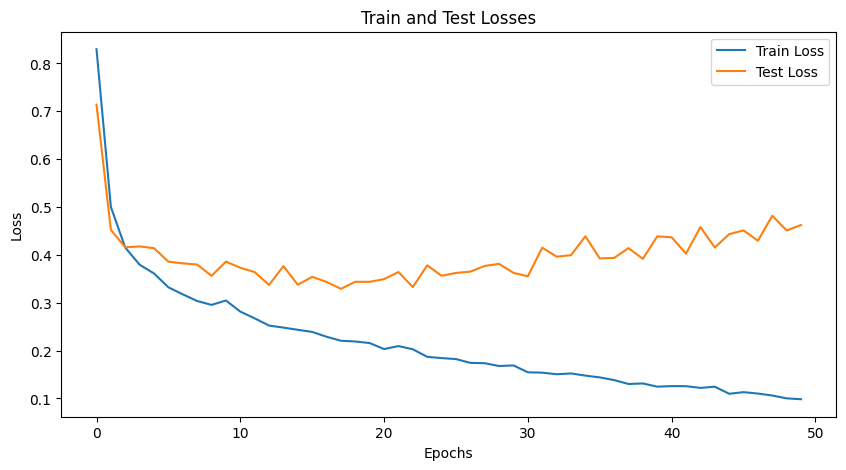

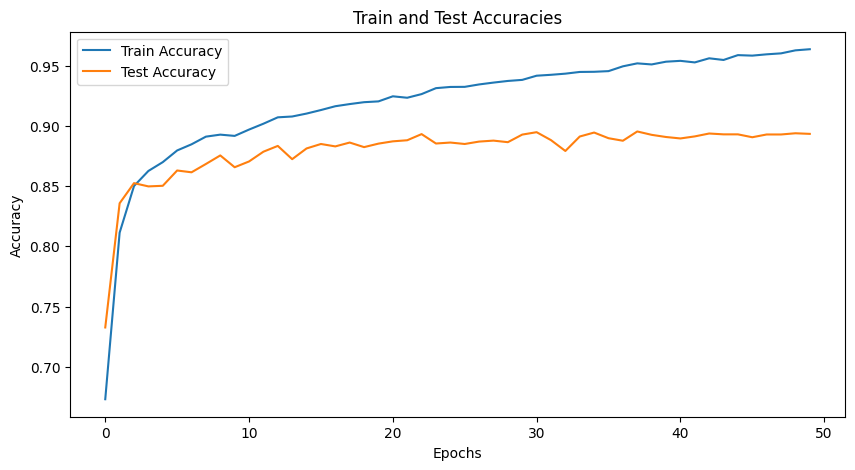

In [ ]:
model = OverfittingNeuralNetwork().to(device)

# Your experiments, come here
model = OverfittingNeuralNetwork().to(device)


loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)


    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Test Loss: {test_losses[-1]:.4f} | Test Accuracy: {test_accuracies[-1]:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies')
plt.legend()
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(input_shape, affine=False),
            nn.Linear(input_shape, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200, affine=False),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
       BatchNorm1d-3                  [-1, 784]               0
            Linear-4                  [-1, 400]         314,000
              ReLU-5                  [-1, 400]               0
            Linear-6                  [-1, 300]         120,300
           Dropout-7                  [-1, 300]               0
              ReLU-8                  [-1, 300]               0
            Linear-9                  [-1, 200]          60,200
             ReLU-10                  [-1, 200]               0
      BatchNorm1d-11                  [-1, 200]               0
             ReLU-12                  [-1, 200]               0
           Linear-13                  [-1, 100]          20,100
             ReLU-14                  [

In [ ]:
model = FixedNeuralNetwork().to(device)

# Your experiments, come here
opt = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted== labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, train_losses[-1], train_accuracies[-1]*100, test_losses[-1], test_accuracies[-1]*100))

Epoch [1/50], Train Loss: 0.5897, Train Accuracy: 79.06%, Test Loss: 0.4292, Test Accuracy: 84.55%
Epoch [2/50], Train Loss: 0.4158, Train Accuracy: 84.91%, Test Loss: 0.3700, Test Accuracy: 86.49%
Epoch [3/50], Train Loss: 0.3836, Train Accuracy: 85.80%, Test Loss: 0.3644, Test Accuracy: 86.67%
Epoch [4/50], Train Loss: 0.3619, Train Accuracy: 86.69%, Test Loss: 0.3502, Test Accuracy: 86.78%
Epoch [5/50], Train Loss: 0.3470, Train Accuracy: 87.14%, Test Loss: 0.3585, Test Accuracy: 86.72%
Epoch [6/50], Train Loss: 0.3372, Train Accuracy: 87.65%, Test Loss: 0.3313, Test Accuracy: 87.84%
Epoch [7/50], Train Loss: 0.3214, Train Accuracy: 88.07%, Test Loss: 0.3321, Test Accuracy: 88.14%
Epoch [8/50], Train Loss: 0.3118, Train Accuracy: 88.42%, Test Loss: 0.3142, Test Accuracy: 88.51%
Epoch [9/50], Train Loss: 0.3025, Train Accuracy: 88.73%, Test Loss: 0.3249, Test Accuracy: 87.87%
Epoch [10/50], Train Loss: 0.2981, Train Accuracy: 88.89%, Test Loss: 0.3145, Test Accuracy: 88.91%
Epoch [11

### Conclusions:
_Write down small report with your conclusions and your ideas._
Исходя из предоставленных результатов, можно сделать следующие выводы:

Первая модель, показала точность на тестовой выборке 89.53%.

Переобученная модель, без применения методов регуляризации, показала следующие результаты:

Train Loss: 0.0983 | Train Accuracy: 0.9636
Test Loss: 0.4624 | Test Accuracy: 0.8933
Здесь видно, что модель показывает очень высокую точность на тренировочной выборке (96.36%), но точность на тестовой выборке ниже (89.33%). Это явный признак переобучения модели.

Исправленная переобученная модель, с применением Dropout и Batch Normalization для регуляризации, показала следующие результаты:

Train Loss: 0.1878 | Train Accuracy: 92.89%
Test Loss: 0.3002 | Test Accuracy: 90.14%
Здесь видно, что точность на тренировочной выборке немного снизилась (92.89%), но точность на тестовой выборке повысилась (90.14%). Это указывает на то, что применение методов регуляризации помогло снизить переобучение и улучшить обобщающую способность модели.

В целом, применение Dropout и Batch Normalization для регуляризации модели помогло улучшить ее способность к обобщению и снизить переобучение. Точность на тестовой выборке повысилась, что является положительным результатом.